<a href="https://colab.research.google.com/github/AhmedHeshamSakr/ML-Models-Comparison-and-Evaluation-/blob/main/Titanic_Naive_Bayes_Classifier_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mounting the Drive and Loading Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
!pip install seaborn
!pip install scikit-learn

In [ ]:
titanic_data = pd.read_csv('/content/drive/MyDrive/kaggle/Titanic/train.csv')


In [ ]:
titanic_data


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# **Preprocessing and Feature Selection**

<ipython-input-7-2f428ec4661c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(titanic_data.corr(), cmap="inferno")


<Axes: >

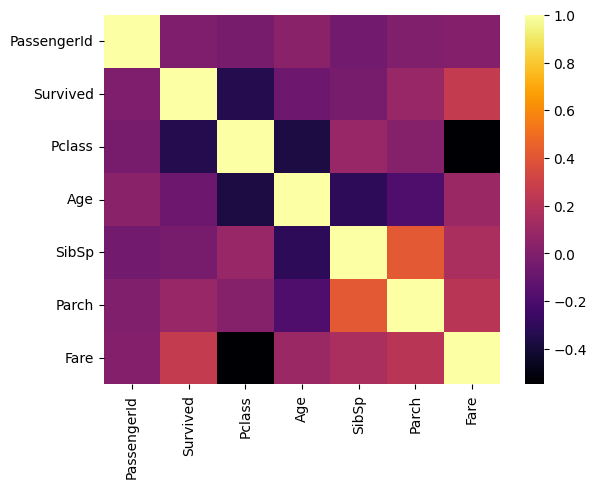

In [ ]:
sns.heatmap(titanic_data.corr(), cmap="inferno")

In [ ]:
# Define features and labels
features = titanic_data.drop('Survived', axis=1)
labels = titanic_data['Survived']

#the first split (training and test)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=40)

for train_indices, test_indices in splitter.split(features, labels):
    train_set = titanic_data.loc[train_indices]
    test_set = titanic_data.loc[test_indices]

#split the training set into training and validation
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_indices, valid_indices in splitter.split(train_set, train_set[["Survived", "Pclass", "Sex"]]):
    train_set = titanic_data.loc[train_indices]
    valid_set = titanic_data.loc[valid_indices]

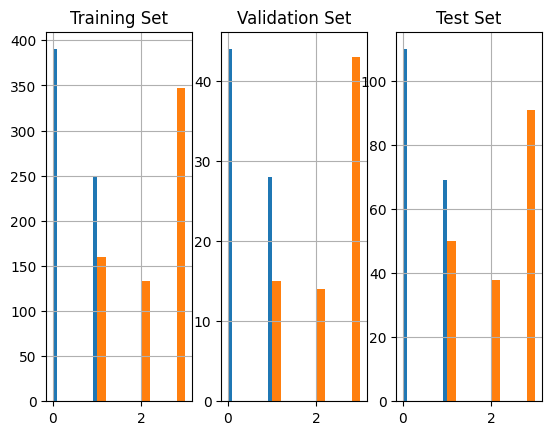

In [ ]:
plt.subplot(1, 3, 1)
train_set['Survived'].hist()
train_set['Pclass'].hist()
plt.title('Training Set')

plt.subplot(1, 3, 2)
valid_set['Survived'].hist()
valid_set['Pclass'].hist()
plt.title('Validation Set')

plt.subplot(1, 3, 3)
test_set['Survived'].hist()
test_set['Pclass'].hist()
plt.title('Test Set')

plt.show()


In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 581 to 355
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  640 non-null    int64  
 1   Survived     640 non-null    int64  
 2   Pclass       640 non-null    int64  
 3   Name         640 non-null    object 
 4   Sex          640 non-null    object 
 5   Age          510 non-null    float64
 6   SibSp        640 non-null    int64  
 7   Parch        640 non-null    int64  
 8   Ticket       640 non-null    object 
 9   Fare         640 non-null    float64
 10  Cabin        149 non-null    object 
 11  Embarked     639 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 65.0+ KB


In [ ]:
class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        imputer = SimpleImputer(strategy="mean")
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X


In [ ]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):

        # One-hot encode 'Sex' column
        sex_encoder = OneHotEncoder()
        sex_matrix = sex_encoder.fit_transform(X[['Sex']]).toarray()
        sex_column_names = ["Female", "Male"]

        for i in range(len(sex_matrix.T)):
            X[sex_column_names[i]] = sex_matrix.T[i]


        return X

In [ ]:
class FeatureDropper (BaseEstimator, TransformerMixin) :
    def fit (self, X, Y=None) :
        return self
    def transform (self, X) :
        return X.drop (["Embarked", "Name", "Ticket", "Cabin", "Sex", "N", "PassengerId"], axis=1 , errors="ignore" )

In [ ]:
preprocessing_pipeline = Pipeline([
    ("AgeImputer", AgeImputer()),
    ("FeatureEncoder", FeatureEncoder()),
    ("FeatureDropper", FeatureDropper()),
    ("Scaler", StandardScaler())
])

In [ ]:
X_train_processed = preprocessing_pipeline.fit_transform(train_set)
X_valid_processed = preprocessing_pipeline.transform(valid_set)
X_test_processed = preprocessing_pipeline.transform(test_set)

### Separate features and labels

In [ ]:
#training
X_train = train_set.drop(['Survived'], axis=1)
y_train = train_set['Survived']
y_train_data = y_train.to_numpy()

#validation
X_valid = valid_set.drop(['Survived'], axis=1)
y_valid = valid_set['Survived']
y_valid_data = y_valid.to_numpy()

#test
X_test = test_set.drop(['Survived'], axis=1)
y_test = test_set['Survived']
y_test_data = y_test.to_numpy()


X_train_data = preprocessing_pipeline.fit_transform(X_train)
X_valid_data = preprocessing_pipeline.transform(X_valid)
X_test_data = preprocessing_pipeline.transform(X_test)


# **The Naive Bayes Classification Model**

In [ ]:

class NaiveBayes:

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # calculate mean, var, and prior for each class
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = np.nanmean(X_c.astype(np.float64), axis=0)
            self._var[idx, :] = np.nanvar(X_c.astype(np.float64), axis=0)
            self._priors[idx] = X_c.shape[0] / float(n_samples)

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []

        # calculate posterior probability for each class
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            posterior = np.sum(np.log(self._pdf(idx, x)))
            posterior = posterior + prior
            posteriors.append(posterior)

        # return class with the highest posterior
        return self._classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(-((x - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator


    def predict_proba(self, X):
        y_pred_proba = [self._predict_proba(x) for x in X]
        return np.array(y_pred_proba)

    def _predict_proba(self, x):
        posteriors = []

        # calculate posterior probability for each class
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            posterior = np.sum(np.log(self._pdf(idx, x)))
            posterior = posterior + prior
            posteriors.append(posterior)

        # Convert to probabilities
        probabilities = np.exp(posteriors) / np.sum(np.exp(posteriors))

        return probabilities






# **Fitting and Prediction**

In [ ]:
if __name__ == "__main__":

    nb = NaiveBayes()
    nb.fit(X_train_data.astype(np.float64), y_train_data.astype(np.float64))

    # Training accuracy
    predictions_train = nb.predict(X_train_data.astype(np.float64))
    accuracy_train = np.sum(predictions_train == y_train_data.astype(np.float64)) / len(y_train_data)
    print("Training Accuracy:", accuracy_train)

    # Validation accuracy
    predictions_valid = nb.predict(X_valid_data.astype(np.float64))
    accuracy_valid = np.sum(predictions_valid == y_valid_data.astype(np.float64)) / len(y_valid_data)
    print("Validation Accuracy:", accuracy_valid)

    # Testing accuracy
    predictions_test = nb.predict(X_test_data.astype(np.float64))
    accuracy_test = np.sum(predictions_test == y_test_data.astype(np.float64)) / len(y_test_data)
    print("Testing Accuracy:", accuracy_test)

Training Accuracy: 0.784375
Validation Accuracy: 0.8194444444444444
Testing Accuracy: 0.8268156424581006


# **Evaluation Metrics**

### Validation Metrics

In [ ]:
print("Shapes:", y_valid_data.shape, len(predictions_valid))
# Evaluate the model on the validation set
accuracy = accuracy_score(y_valid_data, predictions_valid)
print(f'Accuracy on the validation set: {accuracy:.2f}')
# Additional evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_valid_data, predictions_valid))
print("\nClassification Report:")
print(classification_report(y_valid_data, predictions_valid))

Shapes: (72,) 72
Accuracy on the validation set: 0.82
Confusion Matrix:
[[40  4]
 [ 9 19]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86        44
           1       0.83      0.68      0.75        28

    accuracy                           0.82        72
   macro avg       0.82      0.79      0.80        72
weighted avg       0.82      0.82      0.82        72



### Testing Metrics

In [ ]:
print("Shapes:", y_test_data.shape, len(predictions_test))
# Evaluate the model on the Testing set
accuracy = accuracy_score(y_test_data, predictions_test)
print(f'Accuracy on the testing set: {accuracy:.2f}')
# Additional evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test_data, predictions_test))
print("\nClassification Report:")
print(classification_report(y_test_data, predictions_test))

Shapes: (179,) 179
Accuracy on the testing set: 0.83
Confusion Matrix:
[[97 13]
 [18 51]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       110
           1       0.80      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179



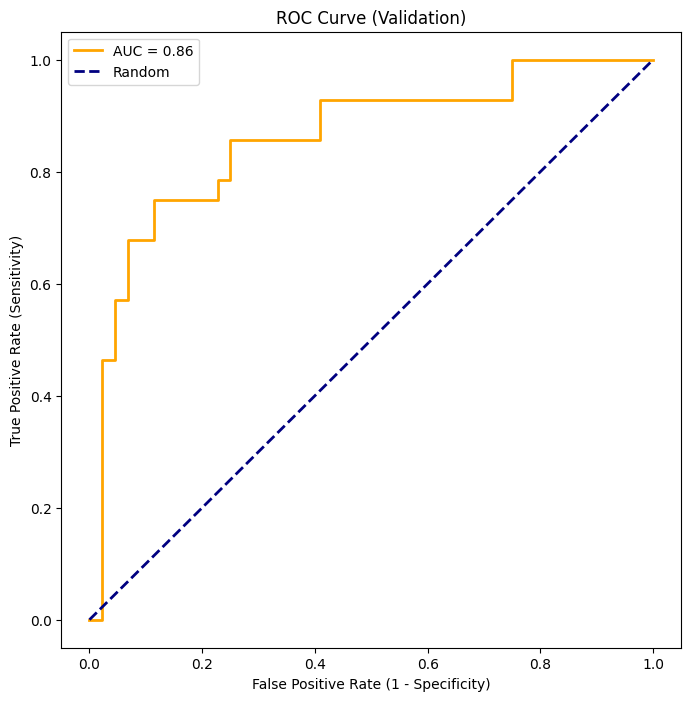

In [ ]:
if __name__ == "__main__":

    nb = NaiveBayes()
    nb.fit(X_train_data.astype(np.float64), y_train_data.astype(np.float64))

    # Get predicted probabilities for the positive class (class 1)
    y_valid_probs = nb.predict_proba(X_valid_data)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_valid_data, y_valid_probs)
    auc = roc_auc_score(y_valid_data, y_valid_probs)

    # Plot ROC Curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='orange', lw=2, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve (Validation)')
    plt.legend()
    plt.show()


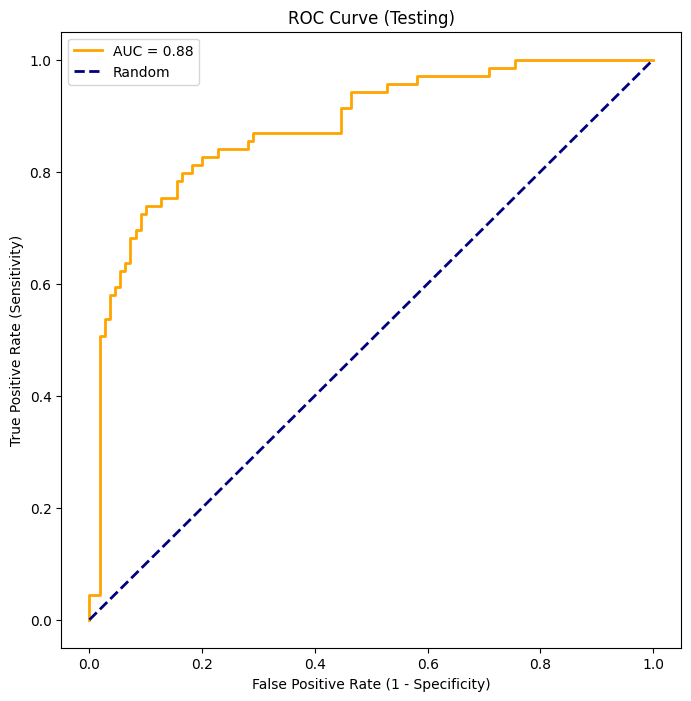

In [ ]:
if __name__ == "__main__":

    nb = NaiveBayes()
    nb.fit(X_train_data.astype(np.float64), y_train_data.astype(np.float64))

    # Get predicted probabilities for the positive class (class 1)
    y_test_probs = nb.predict_proba(X_test_data)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test_data, y_test_probs)
    auc = roc_auc_score(y_test_data, y_test_probs)

    # Plot ROC Curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='orange', lw=2, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve (Testing)')
    plt.legend()
    plt.show()
